<font size=6>
    <b>Sentiment_Analysis.ipynb:</b> Sentiment Analysis with Pandas and Watson Natural Language Understanding
 </font>

# Introduction

With the significant growth in the volume of highly subjective user-generated text in the form of online products reviews, recommendations, blogs, discussion forums and etc., the sentiment analysis has gained a lot of attention in the last decade. The sentiment analysis goal is to automatically detect the underlying sentiment of the user towards the entity of interest. While the Sentiment analysis is  one of the most prominent and commonly used natural language processing (NLP) features, it is typically used in combination with other NLP features and text analytics to gain insight about the user experience for the sake of customer care and feedback analytics, product analytics and brand intelligence.
This notebook shows how the open source library [Text Extensions for Pandas](https://github.com/CODAIT/text-extensions-for-pandas) lets you use use [Pandas](https://pandas.pydata.org/) DataFrames and the [Watson Natural Language Understanding](https://www.ibm.com/cloud/watson-natural-language-understanding) service to conduct exploratory sentiment analysis over the product reviews. 

We start out with a dataset from the [Edmunds-Consumer Car Ratings and Reviews](https://www.kaggle.com/ankkur13/edmundsconsumer-car-ratings-and-reviews) obtained from the Kaggle datasets. This is a dataset containing consumer's thought and the star rating of car manufacturer/model/type.
We pass each review to the Watson Natural Language 
Understanding (NLU) service. Then we use Text Extensions for Pandas to convert the output of the 
Watson NLU service to Pandas DataFrames. Next, we perform an example exploratory data analysis and machine learning task with 
Pandas to show how Pandas makes analyzing the dataset and prediction task much easier.

# Environment Setup

This notebook requires a Python 3.7 or later environment with the following packages:
* The dependencies listed in the ["requirements.txt" file for Text Extensions for Pandas](https://github.com/CODAIT/text-extensions-for-pandas/blob/master/requirements.txt)
* The "[ibm-watson](https://pypi.org/project/ibm-watson/)" package, available via `pip install ibm-watson`
* `text_extensions_for_pandas`

You can satisfy the dependency on `text_extensions_for_pandas` in either of two ways:

* Run `pip install text_extensions_for_pandas` before running this notebook. This command adds the library to your Python environment.
* Run this notebook out of your local copy of the Text Extensions for Pandas project's [source tree](https://github.com/CODAIT/text-extensions-for-pandas). In this case, the notebook will use the version of Text Extensions for Pandas in your local source tree **if the package is not installed in your Python environment**.

In [1]:
# Core Python libraries
import json
import os
import sys
import pandas as pd
import numpy as np
import glob
import re
import warnings
from typing import *

# IBM Watson libraries
import ibm_watson
import ibm_watson.natural_language_understanding_v1 as nlu
import ibm_cloud_sdk_core

# Machine Learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Visualization
import matplotlib.pyplot as plt


# And of course we need the text_extensions_for_pandas library itself.
try:
    import text_extensions_for_pandas as tp
except ModuleNotFoundError as e:
    # If we're running from within the project source tree and the parent Python
    # environment doesn't have the text_extensions_for_pandas package, use the
    # version in the local source tree.
    if not os.getcwd().endswith("notebooks"):
        raise e
    if ".." not in sys.path:
        sys.path.insert(0, "..")
    import text_extensions_for_pandas as tp

# Set up the Watson Natural Language Understanding Service

In this part of the notebook, we will use the Watson Natural Language Understanding (NLU) service to extract the keywords and their sentiment and emotion from each of the product reviews.

You can create an instance of Watson NLU on the IBM Cloud for free by navigating to [this page](https://www.ibm.com/cloud/watson-natural-language-understanding) and clicking on the button marked "Get started free". You can also install your own instance of Watson NLU on [OpenShift](https://www.openshift.com/) by using [IBM Watson Natural Language Understanding for IBM Cloud Pak for Data](
https://catalog.redhat.com/software/operators/detail/5e9873e13f398525a0ceafe5).

You'll need two pieces of information to access your instance of Watson NLU: An **API key** and a **service URL**. If you're using Watson NLU on the IBM Cloud, you can find your API key and service URL in the IBM Cloud web UI. Navigate to the [resource list](https://cloud.ibm.com/resources) and click on your instance of Natural Language Understanding to open the management UI for your service. Then click on the "Manage" tab to show a page with your API key and service URL.

The cell that follows assumes that you are using the environment variables `IBM_API_KEY` and `IBM_SERVICE_URL` to store your credentials. If you're running this notebook in Jupyter on your laptop, you can set these environment variables while starting up `jupyter notebook` or `jupyter lab`. For example:
``` console
IBM_API_KEY='<my API key>' \
IBM_SERVICE_URL='<my service URL>' \
  jupyter lab
```

Alternately, you can uncomment the first two lines of code below to set the `IBM_API_KEY` and `IBM_SERVICE_URL` environment variables directly.
**Be careful not to store your API key in any publicly-accessible location!**

In [2]:
# If you need to embed your credentials inline, uncomment the following two lines and
# paste your credentials in the indicated locations.
# os.environ["IBM_API_KEY"] = "<API key goes here>"
# os.environ["IBM_SERVICE_URL"] = "<Service URL goes here>"

# Retrieve the API key for your Watson NLU service instance
if "IBM_API_KEY" not in os.environ:
    raise ValueError("Expected Watson NLU api key in the environment variable 'IBM_API_KEY'")
api_key = os.environ.get("IBM_API_KEY")
    
# Retrieve the service URL for your Watson NLU service instance
if "IBM_SERVICE_URL" not in os.environ:
    raise ValueError("Expected Watson NLU service URL in the environment variable 'IBM_SERVICE_URL'")
service_url = os.environ.get("IBM_SERVICE_URL")  

# Connect to the Watson Natural Language Understanding Python API

This notebook uses the IBM Watson Python SDK to perform authentication on the IBM Cloud via the 
`IAMAuthenticator` class. See [the IBM Watson Python SDK documentation](https://github.com/watson-developer-cloud/python-sdk#iam) for more information. 

We start by using the API key and service URL from the previous cell to create an instance of the
Python API for Watson NLU.

In [3]:
natural_language_understanding = ibm_watson.NaturalLanguageUnderstandingV1(
    version="2019-07-12",
    authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key)
)
natural_language_understanding.set_service_url(service_url)
natural_language_understanding.set_disable_ssl_verification(True)

# Pass a Review through the Watson NLU Service

Once you've opened a connection to the Watson NLU service, you can pass documents through 
the service by invoking the [`analyze()` method](https://cloud.ibm.com/apidocs/natural-language-understanding?code=python#analyze).

To do so, we have downloaded [Edmunds-Consumer Car Ratings and Reviews](https://www.kaggle.com/ankkur13/edmundsconsumer-car-ratings-and-reviews) from the Kaggle website and copied that to our resources directory. Note that the directory of the dataset contains 50 csv files of reviews of 50 major car brands which we read into one dataframe with the brand name is listed under the "Car_Make" column.

Let's read the reviews and show what the reviews looks like:

In [4]:
path = r'../resources/archive' # path to data
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=0, header=0, lineterminator='\n')
    df['Car_Make'] = re.split('_|\\.',os.path.basename(filename))[-2] # Extracting the car brand from file name
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame.head(10)

Review_Date       Author_Name  \
0   on 09/18/11 00:19 AM (PDT)       wizbang_fl    
1   on 07/07/10 05:28 AM (PDT)   carlo frazzano    
2   on 10/19/09 21:41 PM (PDT)  NewBeetleDriver    
3   on 01/01/09 19:13 PM (PST)         Kayemtee    
4   on 08/02/08 13:43 PM (PDT)              jik    
5   on 05/16/08 12:07 PM (PDT)     Ray Cavanagh    
6   on 03/28/08 22:04 PM (PDT)      harvestmoon    
7   on 01/03/08 17:53 PM (PST)      The Husband    
8   on 09/27/07 08:42 AM (PDT)         Kristina    
9   on 08/01/07 22:24 PM (PDT)        bug lover    

                                       Vehicle_Title  \
0  2007 Volkswagen New Beetle Convertible 2.5 2dr...   
1  2007 Volkswagen New Beetle Convertible 2.5 PZE...   
2  2007 Volkswagen New Beetle Convertible Triple ...   
3  2007 Volkswagen New Beetle Convertible 2.5 2dr...   
4  2007 Volkswagen New Beetle Convertible 2.5 2dr...   
5  2007 Volkswagen New Beetle Convertible Triple ...   
6  2007 Volkswagen New Beetle Convertible 2.5 2dr...   
7  2007 Volkswagen New Beetle Convertible Triple ...   
8  2007 Volkswagen New Beetle Convertible 2.5 2dr...   
9  2007 Volkswagen New Beetle Convertible Triple ...   

                                        Review_Title  \
0  New Beetle- Holds up well & Fun to Drive, but ...   
1                                     Quality Review   
2                                           Adore it   
3                                        Nice Ragtop   
4                         Luv, luv, luv my dream car   
5                            The Best One So Far....   
6                   Don't Fall Under The Cute Spell!   
7                            Not for Cold Weather!!!   
8                                   I love my Beetle   
9                                   Bug lover review   

                                              Review  Rating\r    Car_Make  
0   I've had my Beetle Convertible for over 4.5 y...     4.500  Volkswagen  
1   We bought the car new in 2007 and are general...     4.375  Volkswagen  
2   I adore my New Beetle. Even though I'm a male...     4.375  Volkswagen  
3   My wife chose this car to replace a Sebring c...     4.375  Volkswagen  
4   4 of us carpool 1 way 30 min.  Backseat ok fo...     4.750  Volkswagen  
5   I owned a 2002 SLK and 2003 BMW Z-4.  After s...     5.000  Volkswagen  
6   Fell in love with the car's look and would be...     2.750  Volkswagen  
7   The car is beautiful and performs well in the...     3.750  Volkswagen  
8   I love my car.  I previously owned an Explore...     5.000  Volkswagen  
9   My 2005 was so good, I had to have the Triple...     5.000  Volkswagen

Let's see how many car models, reviews and reviewers and etc. we have per car make in our dataset:

In [5]:
frame.groupby('Car_Make').nunique()

Review_Date  Author_Name  Vehicle_Title  Review_Title  Review  \
Car_Make                                                                       
AMGeneral                5            5              2             5       5   
Acura                 5632         5807            494          5682    6512   
AlfaRomeo               77           76             22            77      77   
AstonMartin             82           89             31            89      89   
Audi                  5069         5389            753          5467    6006   
BMW                   6833         7106            829          7203    7984   
Bentley                150          146             39           141     150   
Bugatti                  9            9              4             9       9   
Buick                 3406         3242            374          3334    3615   
Cadillac              3539         3531            457          3593    3902   
Chevrolet            15781        16254           2760         16501   19334   
GMC                   4327         4425           1261          4415    4964   
Honda                11611        10646           1704         11142   12559   
Toyota               16145        15483           2328         15914   18553   
Volkswagen            8260         8219           1577          8481    9334   
chrysler              4958         4960            495          4997    5529   
dodge                 6781         7373           1173          7463    8460   
ferrari                156          159             47           156     161   
fiat                   394          380             68           391     391   
ford                 16908        17136           3261         17719   20576   
genesis                 78           75             16            78      77   
hummer                 537          541             35           531     559   
hyundai               7679         7032            943          7250    8156   
infiniti              3914         3874            370          3846    4277   
isuzu                 1002         1146            175          1093    1173   
jaguar                1730         1729            254          1770    1878   
jeep                  4824         4311            643          4540    4932   
kia                   5561         5225            705          5353    5926   
lamborghini             83           85             24            82      86   
land-rover            1752         1711            186          1743    1831   
lexus                 5371         5474            370          5424    6083   
lincoln               2801         2776            308          2792    3012   
lotus                  136          133             16           133     137   
maserati               235          234             61           234     239   
maybach                 24           24              6            24      24   
mazda                 7165         6830            938          7036    7820   
mclaren                  1            1              1             1       1   
mercedes-benz         6063         6542            804          6639    7308   
mercury               3002         3002            291          3038    3355   
mini                  1033          977            127           997    1036   
mitsubishi            3982         4382            601          4222    4773   
nissan               10729        10025           1735         10402   11760   
pontiac               5066         5294            345          5239    5927   
porsche               1636         1646            280          1657    1774   
ram                    564          505            281           551     553   
rolls-royce             33           34             15            33      33   
subaru                5994         5711            970          5958    6510   
suzuki                2142         2151            460          2124    2326   
tesla          

And number of the car makes:

In [6]:
frame.groupby('Car_Make').nunique().shape[0]

50

Let's then sample randomly from the dataframe by keeping <=200 of the records per car make:

In [7]:
n = 200
#df.groupby('Group_Id').apply(lambda x: x.sample(min(n,len(x)))).reset_index(drop=True)
sampled_df = frame.groupby('Car_Make').apply(lambda x: x.sample(min(n,len(x)))).reset_index(drop=True)
sampled_df.nunique()

Review_Date      7279
Author_Name      7451
Vehicle_Title    5249
Review_Title     7698
Review           8339
Rating\r           33
Car_Make           50
dtype: int64

Checking the number of reviews and columns in the imported corpus:

In [8]:
sampled_df.shape

(8392, 7)

Let's combine the review titles and the review into the review_content for the later analysis:

In [9]:
sampled_df['Review_Content'] = sampled_df['Review_Title']+ ':' + sampled_df['Review']
sampled_df.head()

Review_Date   Author_Name  \
0   on 01/19/06 19:46 PM (PST)       REUBEN    
1   on 06/15/02 00:00 AM (PDT)     mike6382    
2   on 08/23/03 00:00 AM (PDT)  Bobby Keene    
3   on 08/30/02 00:00 AM (PDT)   bluice3309    
4   on 12/18/05 19:55 PM (PST)     Clayton     

                                     Vehicle_Title          Review_Title  \
0  2000 AM General Hummer SUV Hard Top 4dr SUV AWD        AWESOME HUMMER   
1  2000 AM General Hummer SUV Hard Top 4dr SUV AWD          What a waste   
2  2000 AM General Hummer SUV Hard Top 4dr SUV AWD             H1 Review   
3           2000 AM General Hummer SUV 4dr SUV AWD           a true ride   
4           2000 AM General Hummer SUV 4dr SUV AWD  HUMMER NOT A bummer    

                                              Review  Rating\r   Car_Make  \
0   Hummer is unstoppable. May only get 12 mpg bu...     5.000  AMGeneral   
1   I have owned this car for a year and a \rhalf...     1.000  AMGeneral   
2   The truck is incredible.  I have a long histo...     4.500  AMGeneral   
3   this beast can go through just about \ranythi...     4.625  AMGeneral   
4   Vehicle is a beast. I don't recommend HUMMER ...     5.000  AMGeneral   

                                      Review_Content  
0  AWESOME HUMMER: Hummer is unstoppable. May onl...  
1  What a waste: I have owned this car for a year...  
2  H1 Review: The truck is incredible.  I have a ...  
3  a true ride: this beast can go through just ab...  
4  HUMMER NOT A bummer : Vehicle is a beast. I do...

Let's see what the reiews look like in our dataset by showing one:

In [10]:
sampled_df['Review_Content'][0]

'AWESOME HUMMER: Hummer is unstoppable. May only get 12 mpg but who really cares. Not anyone that matters anyway. I cant get it stuck. I love the standard 12000 pound winch. 83 mph is "rated" top speed but I have experienced 87. It handles great at that speed. It is a little loud though. '

Now it is time to check how Watson Natural Language Understanding can help us analyzing the reviews starting from the first review:

In the code below, we instruct Watson Natural Language Understanding to perform five different kinds of analysis on the first review:
* entities (with sentiment)
* keywords (with sentiment and emotion)
* relations
* semantic_roles
* syntax (with sentences, tokens, and part of speech)

See [the Watson NLU documentation](https://cloud.ibm.com/apidocs/natural-language-understanding?code=python#text-analytics-features) for a full description of the types of analysis that NLU can perform.

In [11]:
# Using Watson Natural Language Understanding for analyzing the Review_Content
# Make the request
nlu_response_review = natural_language_understanding.analyze(
    text=sampled_df['Review_Content'][0],
    return_analyzed_text=True,
    features=nlu.Features(
        entities=nlu.EntitiesOptions(sentiment=True, mentions=True),
        keywords=nlu.KeywordsOptions(sentiment=True, emotion=True),
        relations=nlu.RelationsOptions(),
        semantic_roles=nlu.SemanticRolesOptions(),
        syntax=nlu.SyntaxOptions(sentences=True, 
                                 tokens=nlu.SyntaxOptionsTokens(lemma=True, part_of_speech=True))
    )).get_result()


/Users/monireh/opt/anaconda3/envs/text-extensions-for-pandas/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.us-south.natural-language-understanding.watson.cloud.ibm.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


The response from the analyze() method is a Python dictionary. The dictionary contains an entry for each pass of analysis requested, plus some additional entries with metadata about the API request itself. Here's a list of the keys in response:

In [12]:
nlu_response_review.keys()

dict_keys(['usage', 'syntax', 'semantic_roles', 'relations', 'language', 'keywords', 'entities', 'analyzed_text'])

And here's the whole output of Watson NLU's text analysis for the first review in the dataset:

In [13]:
nlu_response_review

{'usage': {'text_units': 1, 'text_characters': 288, 'features': 5},
 'syntax': {'tokens': [{'text': 'AWESOME',
    'part_of_speech': 'ADJ',
    'location': [0, 7],
    'lemma': 'awesome'},
   {'text': 'HUMMER',
    'part_of_speech': 'NOUN',
    'location': [8, 14],
    'lemma': 'hummer'},
   {'text': ':',
    'part_of_speech': 'PUNCT',
    'location': [14, 15],
    'lemma': ':'},
   {'text': 'Hummer',
    'part_of_speech': 'NOUN',
    'location': [16, 22],
    'lemma': 'hummer'},
   {'text': 'is',
    'part_of_speech': 'AUX',
    'location': [23, 25],
    'lemma': 'be'},
   {'text': 'unstoppable',
    'part_of_speech': 'ADJ',
    'location': [26, 37],
    'lemma': 'unstoppable'},
   {'text': '.', 'part_of_speech': 'PUNCT', 'location': [37, 38]},
   {'text': 'May',
    'part_of_speech': 'AUX',
    'location': [39, 42],
    'lemma': 'may'},
   {'text': 'only',
    'part_of_speech': 'ADV',
    'location': [43, 47],
    'lemma': 'only'},
   {'text': 'get',
    'part_of_speech': 'VERB',
   

Let's explore the output dictionary based on its keys:

In [14]:
nlu_response_review['analyzed_text']

'AWESOME HUMMER: Hummer is unstoppable. May only get 12 mpg but who really cares. Not anyone that matters anyway. I cant get it stuck. I love the standard 12000 pound winch. 83 mph is "rated" top speed but I have experienced 87. It handles great at that speed. It is a little loud though. '

In [15]:
nlu_response_review['keywords']

[{'text': 'AWESOME HUMMER',
  'sentiment': {'score': 0.734681, 'label': 'positive'},
  'relevance': 0.843322,
  'emotion': {'sadness': 0.026814,
   'joy': 0.689077,
   'fear': 0.032324,
   'disgust': 0.015564,
   'anger': 0.019835},
  'count': 1},
 {'text': 'top speed',
  'sentiment': {'score': 0, 'label': 'neutral'},
  'relevance': 0.643458,
  'emotion': {'sadness': 0.089483,
   'joy': 0.101778,
   'fear': 0.07457,
   'disgust': 0.225941,
   'anger': 0.397162},
  'count': 1},
 {'text': 'mph',
  'sentiment': {'score': 0, 'label': 'neutral'},
  'relevance': 0.635404,
  'emotion': {'sadness': 0.089483,
   'joy': 0.101778,
   'fear': 0.07457,
   'disgust': 0.225941,
   'anger': 0.397162},
  'count': 1},
 {'text': 'pound winch',
  'sentiment': {'score': 0.942293, 'label': 'positive'},
  'relevance': 0.601744,
  'emotion': {'sadness': 0.03667,
   'joy': 0.78071,
   'fear': 0.049028,
   'disgust': 0.031229,
   'anger': 0.01223},
  'count': 1},
 {'text': 'standard',
  'sentiment': {'score': 0

For many data scientists and machine learning engineers a common task workflow includes using Pandas to do exploratory data analysis followed by using scikit-learn for applying the machine learning techniques over the data. 

Text Extensions for Pandas includes a function parse_response() that turns the output of Watson NLU's analyze() function into a dictionary of Pandas DataFrames. Let's run our response object through that conversion. Let's first begin by parsing the Watson NLU response by text extensions for pandas, to see what information has been captured for each review:

In [16]:
df_analyzed_review = tp.io.watson.nlu.parse_response(nlu_response_review)
df_analyzed_review

{'syntax':                     span part_of_speech    lemma  \
 0      [0, 7): 'AWESOME'            ADJ  awesome   
 1      [8, 14): 'HUMMER'           NOUN   hummer   
 2          [14, 15): ':'          PUNCT        :   
 3     [16, 22): 'Hummer'           NOUN   hummer   
 4         [23, 25): 'is'            AUX       be   
 ..                   ...            ...      ...   
 60       [266, 267): 'a'            DET        a   
 61  [268, 274): 'little'            ADJ   little   
 62    [275, 279): 'loud'            ADJ     loud   
 63  [280, 286): 'though'            ADV   though   
 64       [286, 287): '.'          PUNCT     None   
 
                                              sentence  
 0   [0, 38): 'AWESOME HUMMER: Hummer is unstoppable.'  
 1   [0, 38): 'AWESOME HUMMER: Hummer is unstoppable.'  
 2   [0, 38): 'AWESOME HUMMER: Hummer is unstoppable.'  
 3   [0, 38): 'AWESOME HUMMER: Hummer is unstoppable.'  
 4   [0, 38): 'AWESOME HUMMER: Hummer is unstoppable.'  
 ..       

In [17]:
df_analyzed_review.keys()

dict_keys(['syntax', 'entities', 'entity_mentions', 'keywords', 'relations', 'semantic_roles'])

The output of each analysis pass that Watson NLU performed is now a DataFrame. Let's look at the DataFrame for the "syntax" pass:

In [18]:
df_analyzed_review['syntax']

span part_of_speech    lemma  \
0      [0, 7): 'AWESOME'            ADJ  awesome   
1      [8, 14): 'HUMMER'           NOUN   hummer   
2          [14, 15): ':'          PUNCT        :   
3     [16, 22): 'Hummer'           NOUN   hummer   
4         [23, 25): 'is'            AUX       be   
..                   ...            ...      ...   
60       [266, 267): 'a'            DET        a   
61  [268, 274): 'little'            ADJ   little   
62    [275, 279): 'loud'            ADJ     loud   
63  [280, 286): 'though'            ADV   though   
64       [286, 287): '.'          PUNCT     None   

                                             sentence  
0   [0, 38): 'AWESOME HUMMER: Hummer is unstoppable.'  
1   [0, 38): 'AWESOME HUMMER: Hummer is unstoppable.'  
2   [0, 38): 'AWESOME HUMMER: Hummer is unstoppable.'  
3   [0, 38): 'AWESOME HUMMER: Hummer is unstoppable.'  
4   [0, 38): 'AWESOME HUMMER: Hummer is unstoppable.'  
..                                                ...  
60          [260, 287): 'It is a little loud though.'  
61          [260, 287): 'It is a little loud though.'  
62          [260, 287): 'It is a little loud though.'  
63          [260, 287): 'It is a little loud though.'  
64          [260, 287): 'It is a little loud though.'  

[65 rows x 4 columns]

The DataFrame has one row for every token in the document. Each row has information on the span of the token, its part of speech, its lemmatized form, and the span of the containing sentence.

In [19]:
df_analyzed_review['semantic_roles']

subject.text                                           sentence  \
0       Hummer             AWESOME HUMMER: Hummer is unstoppable.   
1            I                               I cant get it stuck.   
2            I             I love the standard 12000 pound winch.   
3            I   83 mph is "rated" top speed but I have experi...   
4            I   83 mph is "rated" top speed but I have experi...   
5           It                    It handles great at that speed.   

                      object.text action.verb.text action.verb.tense  \
0                     unstoppable               be           present   
1                              it              get           present   
2  the standard 12000 pound winch             love           present   
3                  experienced 87             have           present   
4                              87       experience              past   
5                           great           handle           present   

        action.text action.normalized  
0                is                be  
1          cant get          cant get  
2              love              love  
3              have              have  
4  have experienced   have experience  
5           handles            handle

Buried in the above data structure is all the information we need to perform our sentence-level sentiment analysis task:


 - The sentiment label and score of every sentence in the review. The score ranges from -1 to 1, with -1 being negative, 0 being neutral and 1 being positive. It provides sentiment on each keyword based on its sentence's sentiment, which can come in useful since it calculates the sentiment in the context.
 - The emotion score of every sentence (i.e., sadness, joy, fear, disgust, and anger) in the review.

 - The list of the most important words/phrases in a review including both sentiment/emotion-bearing words/phrases as well as objective words/phrases in the review extracted under the keywords. Note that the sentiment assigned to each keyword has calculated based on its context and in the sentence level.

In [20]:
df_analyzed_review['keywords']

text sentiment.label  sentiment.score  relevance  \
0  AWESOME HUMMER        positive         0.734681   0.843322   
1       top speed         neutral         0.000000   0.643458   
2             mph         neutral         0.000000   0.635404   
3     pound winch        positive         0.942293   0.601744   
4        standard        positive         0.942293   0.567490   
5             mpg        negative        -0.832303   0.552716   
6          Hummer        positive         0.734681   0.540497   
7           speed         neutral         0.000000   0.522496   

   emotion.sadness  emotion.joy  emotion.fear  emotion.disgust  emotion.anger  \
0         0.026814     0.689077      0.032324         0.015564       0.019835   
1         0.089483     0.101778      0.074570         0.225941       0.397162   
2         0.089483     0.101778      0.074570         0.225941       0.397162   
3         0.036670     0.780710      0.049028         0.031229       0.012230   
4         0.036670     0.780710      0.049028         0.031229       0.012230   
5         0.253996     0.186484      0.164921         0.047823       0.174912   
6         0.026814     0.689077      0.032324         0.015564       0.019835   
7         0.045349     0.288937      0.037827         0.119884       0.271544   

   count  
0      1  
1      1  
2      1  
3      1  
4      1  
5      1  
6      1  
7      1

Now let's concat the watson nlu sentiment analysis dataframe above(output of text enstensions for pandas) with its corresponding review.

In [21]:
keywords_review = pd.concat ([df_analyzed_review['keywords'] , pd.Series([nlu_response_review['analyzed_text']]*len(df_analyzed_review['keywords']))], axis = 1)
keywords_review

text sentiment.label  sentiment.score  relevance  \
0  AWESOME HUMMER        positive         0.734681   0.843322   
1       top speed         neutral         0.000000   0.643458   
2             mph         neutral         0.000000   0.635404   
3     pound winch        positive         0.942293   0.601744   
4        standard        positive         0.942293   0.567490   
5             mpg        negative        -0.832303   0.552716   
6          Hummer        positive         0.734681   0.540497   
7           speed         neutral         0.000000   0.522496   

   emotion.sadness  emotion.joy  emotion.fear  emotion.disgust  emotion.anger  \
0         0.026814     0.689077      0.032324         0.015564       0.019835   
1         0.089483     0.101778      0.074570         0.225941       0.397162   
2         0.089483     0.101778      0.074570         0.225941       0.397162   
3         0.036670     0.780710      0.049028         0.031229       0.012230   
4         0.036670     0.780710      0.049028         0.031229       0.012230   
5         0.253996     0.186484      0.164921         0.047823       0.174912   
6         0.026814     0.689077      0.032324         0.015564       0.019835   
7         0.045349     0.288937      0.037827         0.119884       0.271544   

   count                                                  0  
0      1  AWESOME HUMMER: Hummer is unstoppable. May onl...  
1      1  AWESOME HUMMER: Hummer is unstoppable. May onl...  
2      1  AWESOME HUMMER: Hummer is unstoppable. May onl...  
3      1  AWESOME HUMMER: Hummer is unstoppable. May onl...  
4      1  AWESOME HUMMER: Hummer is unstoppable. May onl...  
5      1  AWESOME HUMMER: Hummer is unstoppable. May onl...  
6      1  AWESOME HUMMER: Hummer is unstoppable. May onl...  
7      1  AWESOME HUMMER: Hummer is unstoppable. May onl...

Let's merge the above dataframe with its corresponding review's information:

In [22]:
(keywords_review.merge(sampled_df, left_on=0, right_on = sampled_df.Review_Content)).drop(columns=[0])

text sentiment.label  sentiment.score  relevance  \
0  AWESOME HUMMER        positive         0.734681   0.843322   
1       top speed         neutral         0.000000   0.643458   
2             mph         neutral         0.000000   0.635404   
3     pound winch        positive         0.942293   0.601744   
4        standard        positive         0.942293   0.567490   
5             mpg        negative        -0.832303   0.552716   
6          Hummer        positive         0.734681   0.540497   
7           speed         neutral         0.000000   0.522496   

   emotion.sadness  emotion.joy  emotion.fear  emotion.disgust  emotion.anger  \
0         0.026814     0.689077      0.032324         0.015564       0.019835   
1         0.089483     0.101778      0.074570         0.225941       0.397162   
2         0.089483     0.101778      0.074570         0.225941       0.397162   
3         0.036670     0.780710      0.049028         0.031229       0.012230   
4         0.036670     0.780710      0.049028         0.031229       0.012230   
5         0.253996     0.186484      0.164921         0.047823       0.174912   
6         0.026814     0.689077      0.032324         0.015564       0.019835   
7         0.045349     0.288937      0.037827         0.119884       0.271544   

   count                  Review_Date Author_Name  \
0      1   on 01/19/06 19:46 PM (PST)     REUBEN    
1      1   on 01/19/06 19:46 PM (PST)     REUBEN    
2      1   on 01/19/06 19:46 PM (PST)     REUBEN    
3      1   on 01/19/06 19:46 PM (PST)     REUBEN    
4      1   on 01/19/06 19:46 PM (PST)     REUBEN    
5      1   on 01/19/06 19:46 PM (PST)     REUBEN    
6      1   on 01/19/06 19:46 PM (PST)     REUBEN    
7      1   on 01/19/06 19:46 PM (PST)     REUBEN    

                                     Vehicle_Title    Review_Title  \
0  2000 AM General Hummer SUV Hard Top 4dr SUV AWD  AWESOME HUMMER   
1  2000 AM General Hummer SUV Hard Top 4dr SUV AWD  AWESOME HUMMER   
2  2000 AM General Hummer SUV Hard Top 4dr SUV AWD  AWESOME HUMMER   
3  2000 AM General Hummer SUV Hard Top 4dr SUV AWD  AWESOME HUMMER   
4  2000 AM General Hummer SUV Hard Top 4dr SUV AWD  AWESOME HUMMER   
5  2000 AM General Hummer SUV Hard Top 4dr SUV AWD  AWESOME HUMMER   
6  2000 AM General Hummer SUV Hard Top 4dr SUV AWD  AWESOME HUMMER   
7  2000 AM General Hummer SUV Hard Top 4dr SUV AWD  AWESOME HUMMER   

                                              Review  Rating\r   Car_Make  \
0   Hummer is unstoppable. May only get 12 mpg bu...       5.0  AMGeneral   
1   Hummer is unstoppable. May only get 12 mpg bu...       5.0  AMGeneral   
2   Hummer is unstoppable. May only get 12 mpg bu...       5.0  AMGeneral   
3   Hummer is unstoppable. May only get 12 mpg bu...       5.0  AMGeneral   
4   Hummer is unstoppable. May only get 12 mpg bu...       5.0  AMGeneral   
5   Hummer is unstoppable. May only get 12 mpg bu...       5.0  AMGeneral   
6   Hummer is unstoppable. May only get 12 mpg bu...       5.0  AMGeneral   
7   Hummer is unstoppable. May only get 12 mpg bu...       5.0  AMGeneral   

                                      Review_Content  
0  AWESOME HUMMER: Hummer is unstoppable. May onl...  
1  AWESOME HUMMER: Hummer is unstoppable. May onl...  
2  AWESOME HUMMER: Hummer is unstoppable. May onl...  
3  AWESOME HUMMER: Hummer is unstoppable. May onl...  
4  AWESOME HUMMER: Hummer is unstoppable. May onl...  
5  AWESOME HUMMER: Hummer is unstoppable. May onl...  
6  AWESOME HUMMER: Hummer is unstoppable. May onl...  
7  AWESOME HUMMER: Hummer is unstoppable. May onl...

# Repeat the Preprocessing over Multiple Reviews
Let's see how we can apply same operations on multiple entries from our car reviews dataset and use the outcome for correlation and sentiment analysis:

In [23]:
warnings.filterwarnings('ignore')
nlu_response_reviews = sampled_df['Review_Content'].dropna().apply(lambda x: natural_language_understanding.analyze(
        text=x,
        language="en",
        return_analyzed_text=True,
        features=nlu.Features(
            keywords=nlu.KeywordsOptions(sentiment=True, emotion=True,
                                        )
                    )).get_result())


In [24]:
tp_parsed_reviews = [tp.io.watson.nlu.parse_response(r) for r in nlu_response_reviews]

In [25]:
tp_parsed_reviews

[{'syntax': Empty DataFrame
  Columns: []
  Index: [],
  'entities': Empty DataFrame
  Columns: []
  Index: [],
  'entity_mentions': Empty DataFrame
  Columns: []
  Index: [],
  'keywords':              text sentiment.label  sentiment.score  relevance  \
  0  AWESOME HUMMER        positive         0.734681   0.843322   
  1       top speed         neutral         0.000000   0.643458   
  2             mph         neutral         0.000000   0.635404   
  3     pound winch        positive         0.942293   0.601744   
  4        standard        positive         0.942293   0.567490   
  5             mpg        negative        -0.832303   0.552716   
  6          Hummer        positive         0.734681   0.540497   
  7           speed         neutral         0.000000   0.522496   
  
     emotion.sadness  emotion.joy  emotion.fear  emotion.disgust  emotion.anger  \
  0         0.026814     0.689077      0.032324         0.015564       0.019835   
  1         0.089483     0.101778      0

That's it. With the DataFrame version of this data, we can perform our exploratory and sentiment analysis task easily with few line of code.

Specifically, we use Pandas  to concat the Watson NLU sentiments dataframe (output of text enstensions for pandas) with its corresponding review, and then we conduct some exploratory analysis on the data.

In [26]:
# Concatenation
keywords_review = [pd.concat ([parsed_review['keywords'] , pd.Series([r['analyzed_text']]*len(parsed_review['keywords']))], axis = 1) for (parsed_review,r) in zip(tp_parsed_reviews,pd.Series(nlu_response_reviews))]
# Convert list of dataframes to the dataframe
keywords_review_df = pd.concat(keywords_review, axis = 0)
keywords_review_df.head(20)

0  count  emotion.anger  \
0  AWESOME HUMMER: Hummer is unstoppable. May onl...    1.0       0.019835   
1  AWESOME HUMMER: Hummer is unstoppable. May onl...    1.0       0.397162   
2  AWESOME HUMMER: Hummer is unstoppable. May onl...    1.0       0.397162   
3  AWESOME HUMMER: Hummer is unstoppable. May onl...    1.0       0.012230   
4  AWESOME HUMMER: Hummer is unstoppable. May onl...    1.0       0.012230   
5  AWESOME HUMMER: Hummer is unstoppable. May onl...    1.0       0.174912   
6  AWESOME HUMMER: Hummer is unstoppable. May onl...    1.0       0.019835   
7  AWESOME HUMMER: Hummer is unstoppable. May onl...    1.0       0.271544   
0  What a waste: I have owned this car for a year...    1.0       0.457683   
1  What a waste: I have owned this car for a year...    1.0       0.665425   
2  What a waste: I have owned this car for a year...    2.0       0.488137   
3  What a waste: I have owned this car for a year...    1.0       0.665425   
4  What a waste: I have owned this car for a year...    1.0       0.457683   
5  What a waste: I have owned this car for a year...    1.0       0.345149   
6  What a waste: I have owned this car for a year...    1.0       0.000000   
0  H1 Review: The truck is incredible.  I have a ...    1.0       0.013115   
1  H1 Review: The truck is incredible.  I have a ...    1.0       0.021514   
2  H1 Review: The truck is incredible.  I have a ...    1.0       0.106156   
3  H1 Review: The truck is incredible.  I have a ...    1.0       0.020686   
4  H1 Review: The truck is incredible.  I have a ...    1.0       0.027269   

   emotion.disgust  emotion.fear  emotion.joy  emotion.sadness  relevance  \
0         0.015564      0.032324     0.689077         0.026814   0.843322   
1         0.225941      0.074570     0.101778         0.089483   0.643458   
2         0.225941      0.074570     0.101778         0.089483   0.635404   
3         0.031229      0.049028     0.780710         0.036670   0.601744   
4         0.031229      0.049028     0.780710         0.036670   0.567490   
5         0.047823      0.164921     0.186484         0.253996   0.552716   
6         0.015564      0.032324     0.689077         0.026814   0.540497   
7         0.119884      0.037827     0.288937         0.045349   0.522496   
0         0.244124      0.130232     0.015328         0.494477   0.685741   
1         0.238400      0.116199     0.010869         0.283251   0.598326   
2         0.223132      0.195960     0.014601         0.407834   0.581432   
3         0.238400      0.116199     0.010869         0.283251   0.577011   
4         0.244124      0.130232     0.015328         0.494477   0.563676   
5         0.351359      0.333530     0.024940         0.245249   0.471689   
6         0.000000      0.000000     0.000000         0.000000   0.471689   
0         0.024451      0.014580     0.721719         0.031339   0.964178   
1         0.055864      0.161380     0.218622         0.279594   0.925094   
2         0.080733      0.094499     0.122194         0.251278   0.720289   
3         0.019377      0.185066     0.033391         0.075380   0.681637   
4         0.037615      0.031214     0.565564         0.069742   0.620892   

  sentiment.label  sentiment.score                     text  
0        positive         0.734681           AWESOME HUMMER  
1         neutral         0.000000                top speed  
2         neutral         0.000000                      mph  
3        positive         0.942293              pound winch  
4        positive         0.942293                 standard  
5        negative        -0.832303                      mpg  
6        positive         0.734681                   Hummer  
7         neutral         0.000000                    speed  
0        negative        -0.875214                    waste  
1        negative        -0.934512                     fire  
2        negative        -0.875214                      car  
3         neutral         0.000000                

Merging each review in the resulted dataframe with its Title, Author, Rating, and other info as below:

In [27]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
merged_keywords_review_df = (keywords_review_df.merge(sampled_df, left_on=0, right_on = sampled_df.Review_Content)).drop(columns=[0])
merged_keywords_review_df

count  emotion.anger  emotion.disgust  emotion.fear  emotion.joy  \
0         1.0       0.019835         0.015564      0.032324     0.689077   
1         1.0       0.397162         0.225941      0.074570     0.101778   
2         1.0       0.397162         0.225941      0.074570     0.101778   
3         1.0       0.012230         0.031229      0.049028     0.780710   
4         1.0       0.012230         0.031229      0.049028     0.780710   
...       ...            ...              ...           ...          ...   
143081    1.0       0.010138         0.003672      0.019318     0.822938   
143082    1.0       0.048828         0.025775      0.135833     0.505808   
143083    1.0       0.120145         0.056586      0.114249     0.309245   
143084    1.0       0.010138         0.003672      0.019318     0.822938   
143085    1.0       0.106476         0.096580      0.075694     0.214198   

        emotion.sadness  relevance sentiment.label  sentiment.score  \
0              0.026814   0.843322        positive         0.734681   
1              0.089483   0.643458         neutral         0.000000   
2              0.089483   0.635404         neutral         0.000000   
3              0.036670   0.601744        positive         0.942293   
4              0.036670   0.567490        positive         0.942293   
...                 ...        ...             ...              ...   
143081         0.113173   0.533828        positive         0.946072   
143082         0.253411   0.528636        positive         0.491182   
143083         0.268630   0.526325        positive         0.758673   
143084         0.113173   0.311252        positive         0.946072   
143085         0.263888   0.305859        positive         0.729722   

                    text                  Review_Date Author_Name  \
0         AWESOME HUMMER   on 01/19/06 19:46 PM (PST)     REUBEN    
1              top speed   on 01/19/06 19:46 PM (PST)     REUBEN    
2                    mph   on 01/19/06 19:46 PM (PST)     REUBEN    
3            pound winch   on 01/19/06 19:46 PM (PST)     REUBEN    
4               standard   on 01/19/06 19:46 PM (PST)     REUBEN    
...                  ...                          ...         ...   
143081               day   on 07/27/18 15:55 PM (PDT)    Janelle    
143082               SUV   on 07/27/18 15:55 PM (PDT)    Janelle    
143083  Volvo dealership   on 07/27/18 15:55 PM (PDT)    Janelle    
143084             years   on 07/27/18 15:55 PM (PDT)    Janelle    
143085               buy   on 07/27/18 15:55 PM (PDT)    Janelle    

                                            Vehicle_Title  \
0         2000 AM General Hummer SUV Hard Top 4dr SUV AWD   
1         2000 AM General Hummer SUV Hard Top 4dr SUV AWD   
2         2000 AM General Hummer SUV Hard Top 4dr SUV AWD   
3         2000 AM General Hummer SUV Hard Top 4dr SUV AWD   
4         2000 AM General Hummer SUV Hard Top 4dr SUV AWD   
...                                                   ...   
143081  2012 Volvo S60 Sedan T5 4dr Sedan (2.5L 5cyl T...   
143082  2012 Volvo S60 Sedan T5 4dr Sedan (2.5L 5cyl T...   
143083  2012 Volvo S60 Sedan T5 4dr Sedan (2.5L 5cyl T...   
143084  2012 Volvo S60 Sedan T5 4dr Sedan (2.5L 5cyl T...   
143085  2012 Volvo S60 Sedan T5 4dr Sedan (2.5L 5cyl T...   

                      Review_Title  \
0                   AWESOME HUMMER   
1                   AWESOME HUMMER   
2                   AWESOME HUMMER   
3                   AWESOME HUMMER   
4                   AWESOME HUMMER   
...                            ...   
143081  Keeping my 2012 Volvo S-60   
143082  Keeping my 2012 Volvo S-60   
143083  Keeping my 2012 Volvo S-60   
143084  Keeping my 2012 Volvo S-60   
143085  Keeping my 2012 Volvo S-60   

                                                   Review  Rating\r  \
0        Hummer is unstoppable. May only get 12 mpg bu...       5.0   
1        Hummer is unstoppable. May only get 12 mpg bu...       5.0   
2        H

In [28]:
grouped_merged_keywords_review_df = merged_keywords_review_df.groupby('Review_Title')
grouped_merged_keywords_review_df.get_group('What a waste').head(30)

count  emotion.anger  emotion.disgust  emotion.fear  emotion.joy  \
8     1.0       0.457683         0.244124      0.130232     0.015328   
9     1.0       0.665425         0.238400      0.116199     0.010869   
10    2.0       0.488137         0.223132      0.195960     0.014601   
11    1.0       0.665425         0.238400      0.116199     0.010869   
12    1.0       0.457683         0.244124      0.130232     0.015328   
13    1.0       0.345149         0.351359      0.333530     0.024940   
14    1.0       0.000000         0.000000      0.000000     0.000000   

    emotion.sadness  relevance sentiment.label  sentiment.score       text  \
8          0.494477   0.685741        negative        -0.875214      waste   
9          0.283251   0.598326        negative        -0.934512       fire   
10         0.407834   0.581432        negative        -0.875214        car   
11         0.283251   0.577011         neutral         0.000000       hell   
12         0.494477   0.563676        negative        -0.875214       year   
13         0.245249   0.471689        negative        -0.665741  reliabile   
14         0.000000   0.471689        negative        -0.813165       time   

                    Review_Date Author_Name  \
8    on 06/15/02 00:00 AM (PDT)   mike6382    
9    on 06/15/02 00:00 AM (PDT)   mike6382    
10   on 06/15/02 00:00 AM (PDT)   mike6382    
11   on 06/15/02 00:00 AM (PDT)   mike6382    
12   on 06/15/02 00:00 AM (PDT)   mike6382    
13   on 06/15/02 00:00 AM (PDT)   mike6382    
14   on 06/15/02 00:00 AM (PDT)   mike6382    

                                      Vehicle_Title  Review_Title  \
8   2000 AM General Hummer SUV Hard Top 4dr SUV AWD  What a waste   
9   2000 AM General Hummer SUV Hard Top 4dr SUV AWD  What a waste   
10  2000 AM General Hummer SUV Hard Top 4dr SUV AWD  What a waste   
11  2000 AM General Hummer SUV Hard Top 4dr SUV AWD  What a waste   
12  2000 AM General Hummer SUV Hard Top 4dr SUV AWD  What a waste   
13  2000 AM General Hummer SUV Hard Top 4dr SUV AWD  What a waste   
14  2000 AM General Hummer SUV Hard Top 4dr SUV AWD  What a waste   

                                               Review  Rating\r   Car_Make  \
8    I have owned this car for a year and a \rhalf...       1.0  AMGeneral   
9    I have owned this car for a year and a \rhalf...       1.0  AMGeneral   
10   I have owned this car for a year and a \rhalf...       1.0  AMGeneral   
11   I have owned this car for a year and a \rhalf...       1.0  AMGeneral   
12   I have owned this car for a year and a \rhalf...       1.0  AMGeneral   
13   I have owned this car for a year and a \rhalf...       1.0  AMGeneral   
14   I have owned this car for a year and a \rhalf...       1.0  AMGeneral   

                                       Review_Content  
8   What a waste: I have owned this car for a year...  
9   What a waste: I have owned this car for a year...  
10  What a waste: I have owned this car for a year...  
11  What a waste: I have owned this car for a year...  
12  What a waste: I have owned this car for a year...  
13  What a waste: I have owned this car for a year...  
14  What a waste: I have owned this car for a year...

As we mentioned above, Watson NLU assigns the sentiment to the keywords based on their context within the sentence. Hence, all keywords within one sentence get the same sentiment score. Thus, to get the aggregated sentiment of each review we calulate the mean sentiment score of its sentences by considering the sentiment assigned to one keyword in each sentence. More specifically, we first drop duplicate sentiment scores for each review and then we calculate the average sentiment and emotion score for each review:

In [29]:
agg_merged_keywords_review_df = merged_keywords_review_df.drop(['count'], axis=1).drop_duplicates(['Review_Title','sentiment.score']).groupby('Review_Title').mean()
agg_merged_keywords_review_df.head(20)

emotion.anger  \
Review_Title                                                        
 02 Silver ///M                                          0.115537   
 2003 Aviator                                            0.003937   
 2007 Kia Rondo LX                                       0.128165   
 A Mistake                                               0.220397   
 AWESOME FUN MY LITTLE TIGER                             0.091981   
 I love my Caliber                                       0.057248   
 Looks Good But Hunk Of Junk                             0.158059   
 Nothing But Problems....Throw-Away Cars                 0.512625   
 The best of both                                        0.149841   
 i'm on my second one                                    0.367577   
! un happy Camper                                        0.125937   
" Use the Force"                                         0.190319   
"02 Merc  Benz C320 Sportwagon - O.K. ?                  0.091763   
"A lot for a little"                                     0.064641   
"Acceleration failure" - Genesis phraseology             0.141623   
"Conservative, Reliable Luxury"                          0.176325   
"Entry-level" headache                                   0.111607   
"First Ride" Impressions when I visited Tesla's...       0.089593   
"Free" Green on green lightning                          0.099248   
"Frequent Flyer" to the dealer service department!       0.139243   

                                                    emotion.disgust  \
Review_Title                                                          
 02 Silver ///M                                            0.073722   
 2003 Aviator                                              0.001667   
 2007 Kia Rondo LX                                         0.077289   
 A Mistake                                                 0.137698   
 AWESOME FUN MY LITTLE TIGER                               0.008174   
 I love my Caliber                                         0.040379   
 Looks Good But Hunk Of Junk                               0.097350   
 Nothing But Problems....Throw-Away Cars                   0.133074   
 The best of both                                          0.070003   
 i'm on my second one                                      0.156578   
! un happy Camper                                          0.161200   
" Use the Force"                                           0.053770   
"02 Merc  Benz C320 Sportwagon - O.K. ?                    0.086141   
"A lot for a little"                                       0.048760   
"Acceleration failure" - Genesis phraseology               0.103167   
"Conservative, Reliable Luxury"                            0.133916   
"Entry-level" headache                                     0.046302   
"First Ride" Impressions when I visited Tesla's...         0.035031   
"Free" Green on green lightning                            0.035117   
"Frequent Flyer" to the dealer service department!         0.054842   

                                                    emotion.fear  emotion.joy  \
Review_Title                                                                    
 02 Silver ///M                                         0.070204     0.250651   
 2003 Aviator                                           0.025108     0.417737   
 2007 Kia Rondo LX                                      0.079710     0.361828   
 A Mistake                                              0.190288     0.188404   
 AWESOME FUN MY LITTLE TIGER                            0.028653     0.888145   
 I love my Caliber                                      0.049315     0.604041   
 Looks Good But Hunk Of Junk                            0.173938     0.283959   
 Nothing But Problems....Throw-Away Cars                0.081369     0.059428   
 The best of both                                       0.104302     0.316318   
 i'm on my second one                                   0.418364     0.043710  

Now we can find the correlation among the variables using pearson method:

In [31]:
corr = agg_merged_keywords_review_df.corr(method ='pearson')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

As the table above shows, there is an association between the review's Ratings and the Watson NLU sentiment score and joy emotion but repulsion between review's Ratings and sadness emotion. The results also demonstrate the strong positive correlation between Watson NLU sentiment score and Watson NLU joy emotion. In contrary, there is a strong negative correlation between sadness emotion and the sentiment score as expected.

# Multivariate Linear Regression
Now let's perform the regression:

To do that, we first need to determine the input features: 

In [32]:
X_df = agg_merged_keywords_review_df.dropna().iloc[:, :6]
X_df

emotion.anger  emotion.disgust  \
Review_Title                                                             
 02 Silver ///M                              0.115537         0.073722   
 2003 Aviator                                0.003937         0.001667   
 2007 Kia Rondo LX                           0.128165         0.077289   
 A Mistake                                   0.220397         0.137698   
 AWESOME FUN MY LITTLE TIGER                 0.091981         0.008174   
...                                               ...              ...   
wow                                          0.110263         0.108233   
wow!!!!! are pt is a Great ride.             0.076875         0.045400   
yes, it is a sports car in an SUV body       0.100224         0.054798   
zoom-zoom                                    0.131321         0.117960   
“My angry little Car” part 2                 0.222577         0.023574   

                                        emotion.fear  emotion.joy  \
Review_Title                                                        
 02 Silver ///M                             0.070204     0.250651   
 2003 Aviator                               0.025108     0.417737   
 2007 Kia Rondo LX                          0.079710     0.361828   
 A Mistake                                  0.190288     0.188404   
 AWESOME FUN MY LITTLE TIGER                0.028653     0.888145   
...                                              ...          ...   
wow                                         0.055796     0.498764   
wow!!!!! are pt is a Great ride.            0.086871     0.507459   
yes, it is a sports car in an SUV body      0.074615     0.232523   
zoom-zoom                                   0.129712     0.374980   
“My angry little Car” part 2                0.098793     0.562225   

                                        emotion.sadness  relevance  
Review_Title                                                        
 02 Silver ///M                                0.091886   0.594468  
 2003 Aviator                                  0.013795   0.696807  
 2007 Kia Rondo LX                             0.163651   0.593350  
 A Mistake                                     0.348810   0.628252  
 AWESOME FUN MY LITTLE TIGER                   0.004321   0.931575  
...                                                 ...        ...  
wow                                            0.120094   0.806299  
wow!!!!! are pt is a Great ride.               0.095349   0.771203  
yes, it is a sports car in an SUV body         0.175905   0.605560  
zoom-zoom                                      0.274147   0.545406  
“My angry little Car” part 2                   0.133871   0.641479  

[7688 rows x 6 columns]

In [33]:
X = X_df.values.reshape(-1, 6)  # values converts it into a numpy array
Y = agg_merged_keywords_review_df.dropna()['Rating\r'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
print(X)
print(Y)

[[0.11553689 0.07372211 0.07020422 0.25065122 0.09188589 0.59446822]
 [0.003937   0.0016675  0.025108   0.4177375  0.013795   0.696807  ]
 [0.1281655  0.0772892  0.0797097  0.3618278  0.1636509  0.5933498 ]
 ...
 [0.10022429 0.05479771 0.07461457 0.232523   0.17590529 0.60556029]
 [0.13132075 0.11796025 0.12971175 0.37498025 0.27414725 0.5454065 ]
 [0.2225772  0.0235742  0.098793   0.5622254  0.133871   0.6414788 ]]
[[4.875]
 [4.   ]
 [4.625]
 ...
 [5.   ]
 [4.625]
 [5.   ]]


Now let's split the dataframe into training and testing sets:

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=9)

We now need to create an instance of the LinearRegression model from Scikit-Learn:

In [35]:
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X_train, Y_train)  # fit the model on the training data

LinearRegression()

Now that the model has been fit we can make predictions by calling the predict command. We are making predictions on the testing set:

In [36]:
Y_pred = linear_regressor.predict(X_test) # make predictions

We'll now check the predictions against the actual values by using the mean squared error (MSE) and R-2 metrics, two metrics commonly used to evaluate regression tasks:

In [37]:
test_set_r2 = r2_score(Y_test, Y_pred)
print(test_set_r2)

mse = mean_squared_error(Y_test, Y_pred)
print(mse)

0.2988316259240833
0.6482978389766711


For every feature we get the coefficient value. Since we have 7 features we get 7 coefficients. Magnitude and direction(+/-) of all these values affect the prediction results.

In [38]:
coef = linear_regressor.coef_
print(coef)
linear_regressor.intercept_

[[-2.18355561 -0.76750358 -0.25810709  0.9605657  -1.9829316  -0.27345046]]


array([4.89451339])

# Predicted Rating against actual Rating plot
We have our predictions in Y_pred. Now lets first create a dataframe for the prediction and actual ratings and then visualize it:

In [39]:
predicted_actual = pd.DataFrame(zip(np.squeeze(Y_pred), np.squeeze(Y)), columns=['Predicted Rating', 'Actual Rating'])
predicted_actual

Predicted Rating  Actual Rating
0             4.610731          4.875
1             3.857064          4.000
2             4.607337          4.625
3             3.369440          3.000
4             3.388556          5.000
...                ...            ...
1533          3.276434          2.625
1534          3.705958          2.750
1535          4.859490          1.000
1536          5.450917          5.000
1537          3.969770          4.625

[1538 rows x 2 columns]

Text(0.5, 1.0, 'Rating From Dataset Vs Rating Predicted By Model')

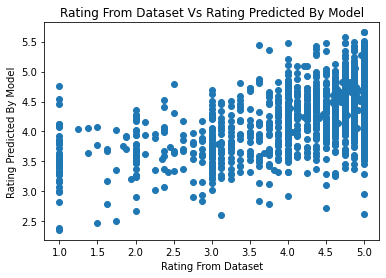

In [40]:
plt.scatter(Y_test, Y_pred)
plt.xlabel('Rating From Dataset')
plt.ylabel('Rating Predicted By Model')
plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
plt.title("Rating From Dataset Vs Rating Predicted By Model")

# Random Forest:

Let's fit Random forest regressor to the dataset:

In [41]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
  
 # create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
  
# fit the regressor with x and y data
regressor.fit(X_train, Y_train)  

RandomForestRegressor(random_state=0)

Predicting a new result:

In [42]:
Y_pred = regressor.predict(X_test)  # test the output by changing values

Reporting mean squared error and R-2 score:

In [43]:
test_set_r2 = r2_score(Y_test, Y_pred)
print(test_set_r2)
mean_squared_error(Y_test, Y_pred)

0.3260404931954214


0.6231406149700138

# Predicted against actual Y plot

Text(0.5, 1.0, 'Rating From Dataset Vs Rating Predicted By Model')

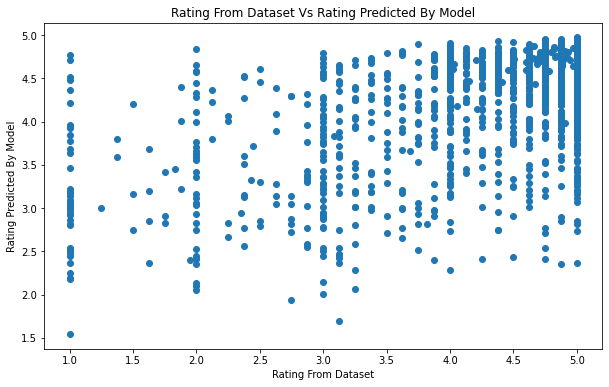

In [44]:
plt.scatter(Y_test, Y_pred)
plt.xlabel('Rating From Dataset')
plt.ylabel('Rating Predicted By Model')
plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
plt.title("Rating From Dataset Vs Rating Predicted By Model")

# Gradient Boosting

Let's try the Gradient Boosting here:

In [45]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, Y_train)
Y_pred = reg.predict(X_test)
print(mean_squared_error(Y_test, Y_pred))
print(r2_score(Y_test, Y_pred))

0.6042599493521411
0.34646093086593965


# Predicted against actual Y plot

Text(0.5, 1.0, 'Rating From Dataset Vs Rating Predicted By Model')

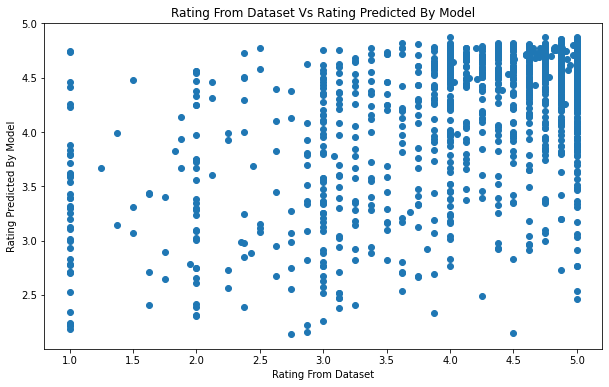

In [46]:
plt.scatter(Y_test, Y_pred)
plt.xlabel('Rating From Dataset')
plt.ylabel('Rating Predicted By Model')
plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
plt.title("Rating From Dataset Vs Rating Predicted By Model")

In [47]:
# Interaction effect in multiple regression:

In [48]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(4, interaction_only=True)
transformed_X_train = poly.fit_transform(X_train)
transformed_X_test = poly.fit_transform(X_test)
reg.fit(transformed_X_train, Y_train)
Y_pred = reg.predict(transformed_X_test)
print(mean_squared_error(Y_test, Y_pred))
print(r2_score(Y_test, Y_pred))

0.5848917060127743
0.36740870960974525


In [49]:
# https://towardsdatascience.com/interaction-effect-in-multiple-regression-3091a5d0fadd
from statsmodels.regression import linear_model
model = linear_model.OLS(Y_train, transformed_X_train).fit()
# From this model we can get the coefficient values and also if they are statistically significant to be included in the model.
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     67.76
Date:                Sun, 18 Apr 2021   Prob (F-statistic):               0.00
Time:                        22:17:41   Log-Likelihood:                -6880.6
No. Observations:                6150   AIC:                         1.388e+04
Df Residuals:                    6093   BIC:                         1.426e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0975      0.625      8.162      0.000       3.873       6.322
x1             3.6828      7.896      0.466      0.641     -11.796      19.162
x2             6.5297      9.573      0.682      0.495     -12.237      25.296
x3            11.0040      6.879      1.600      0.110      -2.482      24.490
x4            -0.6157      0.912     -0.675      0.499      -2.403       1.171
x5           -12.6918      2.938     -4.319      0.000     -18.452      -6.932
x6            -0.1029      0.812     -0.127      0.899      -1.694       1.489
x7           -70.3424     71.161     -0.988      0.323    -209.844      69.159
x8          -152.3228     47.834     -3.184      0.001    -246.095     -58.551
x9            -1.9718     14.521     -0.136      0.892     -30.438      26.494
x10           20.1750     20.575      0.981      0.327     -20.159      60.509
x11           -6.8940     10.062     -0.685      0.493     -26.619      12.831
x12           -7.6434     85.199     -0.090      0.929    -174.664     159.377
x13          -22.3152     19.305     -1.156      0.248     -60.159      15.529
x14            8.4417     27.904      0.303      0.762     -46.260      63.143
x15          -11.9176     11.837     -1.007      0.314     -35.122      11.287
x16          -28.5836     13.638     -2.096      0.036     -55.318      -1.849
x17           10.8817     20.735      0.525      0.600     -29.767      51.531
x18          -15.8596      9.045     -1.753      0.080     -33.591       1.872
x19           30.6744      6.643      4.617      0.000      17.651      43.698
x20            0.8334      1.147      0.727      0.467      -1.414       3.081
x21           12.7062      3.631      3.500      0.000       5.589      19.824
x22          522.0489    284.946      1.832      0.067     -36.545    1080.643
x23          230.3094    144.113      1.598      0.110     -52.204     512.823
x24         -153.2232    150.249     -1.020      0.308    -447.764     141.318
x25           75.7257     95.201      0.795      0.426    -110.902     262.353
x26          359.2376    106.349      3.378      0.001     150.757     567.718
x27          199.2661    111.357      1.789      0.074     -19.033     417.565
x28          186.6131     61.300      3.044      0.002      66.444     306.782
x29         -121.3896     52.549     -2.310      0.021    -224.404     -18.375
x30           -2.7119     18.085     -0.150      0.881     -38.166      32.742
x31          -27.7759     25.434     -1.092      0.275     -77.636      22.084
x32         -156.0929    185.818     -0.840      0.401    -520.361     208.175
x33         -203.2291    207.155     -0.981      0.327    -609.326     202.868
x34           10.0456    109.580      0.092      0.927    -204.771     224.862
x35          128.7951     79.562      1.619      0.106     -27.174     284.765
x3

# Univariate linear regression

Let's focuses on determining relationship between sentiment score and user ranking:

In [50]:
X = agg_merged_keywords_review_df.dropna().iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
Y_ = agg_merged_keywords_review_df.dropna()['Rating\r'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Y

array([[4.875],
       [4.   ],
       [4.625],
       ...,
       [5.   ],
       [4.625],
       [5.   ]])

In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=9)

In [53]:
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X_train, Y_train)  # fit the model on the training data
test_set_mse = mean_squared_error(Y_test, Y_pred)
print(test_set_mse)
test_set_r2 = r2_score(Y_test, Y_pred)
print(test_set_r2)

0.5848917060127743
0.36740870960974525


# Further Evaluations

Let's see how well the model fits the data when it comes to prediction of the Car_Make level ratings. For that we need to keep the Car_Make in our dataset datarame; fit the regression on individual reviews and then calulate the average mean squared error and R-squared in the Car_Make level:

In [54]:
pd.set_option("display.max_colwidth", 10000)
agg_merged_keywords_review_df = merged_keywords_review_df.drop_duplicates(['Review_Title','sentiment.score']).groupby(["Review_Title"]).agg({
                       'sentiment.score': 'mean',
                       'emotion.sadness': 'mean',
                       'emotion.joy': 'mean',
                       'emotion.fear': 'mean',
                       'emotion.disgust': 'mean',
                       'emotion.anger': 'mean',
                       'Rating\r': 'first',
                       'Car_Make': 'first',
                       'Review_Content': 'first'
})
agg_merged_keywords_review_df

sentiment.score  emotion.sadness  \
Review_Title                                                               
 02 Silver ///M                                0.685259         0.091886   
 2003 Aviator                                  0.960970         0.013795   
 2007 Kia Rondo LX                             0.411148         0.163651   
 A Mistake                                    -0.660627         0.348810   
 AWESOME FUN MY LITTLE TIGER                   0.988332         0.004321   
...                                                 ...              ...   
wow                                            0.639631         0.120094   
wow!!!!! are pt is a Great ride.               0.488464         0.095349   
yes, it is a sports car in an SUV body         0.595372         0.175905   
zoom-zoom                                     -0.128785         0.274147   
“My angry little Car” part 2                   0.156629         0.133871   

                                        emotion.joy  emotion.fear  \
Review_Title                                                        
 02 Silver ///M                            0.250651      0.070204   
 2003 Aviator                              0.417737      0.025108   
 2007 Kia Rondo LX                         0.361828      0.079710   
 A Mistake                                 0.188404      0.190288   
 AWESOME FUN MY LITTLE TIGER               0.888145      0.028653   
...                                             ...           ...   
wow                                        0.498764      0.055796   
wow!!!!! are pt is a Great ride.           0.507459      0.086871   
yes, it is a sports car in an SUV body     0.232523      0.074615   
zoom-zoom                                  0.374980      0.129712   
“My angry little Car” part 2               0.562225      0.098793   

                                        emotion.disgust  emotion.anger  \
Review_Title                                                             
 02 Silver ///M                                0.073722       0.115537   
 2003 Aviator                                  0.001667       0.003937   
 2007 Kia Rondo LX                             0.077289       0.128165   
 A Mistake                                     0.137698       0.220397   
 AWESOME FUN MY LITTLE TIGER                   0.008174       0.091981   
...                                                 ...            ...   
wow                                            0.108233       0.110263   
wow!!!!! are pt is a Great ride.               0.045400       0.076875   
yes, it is a sports car in an SUV body         0.054798       0.100224   
zoom-zoom                                      0.117960       0.131321   
“My angry little Car” part 2                   0.023574       0.222577   

                                        Rating\r  Car_Make  \
Review_Title                                                 
 02 Silver ///M                            4.875       BMW   
 2003 Aviator                              4.000   lincoln   
 2007 Kia Rondo LX                         4.625       kia   
 A Mistake                                 3.000     Buick   
 AWESOME FUN MY LITTLE TIGER               5.000      fiat   
...                                          ...       ...   
wow                                        5.000   Bentley   
wow!!!!! are pt is a Great ride.           5.000  chrysler   
yes, it is a sports car in an SUV body     5.000   porsche   
zoom-zoom                                  4.625     mazda   
“My angry little Car” part 2               5.000      fiat   

                                                                                                                                                                                                                                                                                                                                                                                               

In [55]:
train_set = agg_merged_keywords_review_df.sample(frac=0.75, random_state=0)
test_set = agg_merged_keywords_review_df.drop(train_set.index)

In [56]:
train_set.groupby("Car_Make").size()

Car_Make
AMGeneral          5
Acura            158
AlfaRomeo         59
AstonMartin       66
Audi             150
BMW              133
Bentley           96
Bugatti            5
Buick            134
Cadillac         152
Chevrolet        148
GMC              153
Honda            140
Toyota           138
Volkswagen       132
chrysler         135
dodge            139
ferrari           94
fiat             142
ford             139
genesis           49
hummer           144
hyundai          129
infiniti         138
isuzu            140
jaguar           142
jeep             139
kia              138
lamborghini       53
land-rover       146
lexus            132
lincoln          139
lotus             92
maserati         134
maybach           17
mazda            144
mclaren            1
mercedes-benz    121
mercury          133
mini             138
mitsubishi       129
nissan           138
pontiac          120
porsche          131
ram              135
rolls-royce       21
subaru           131
suzu

In [57]:
X_train = train_set['sentiment.score'].values.reshape(-1, 1)
X_test = test_set['sentiment.score'].values.reshape(-1, 1)
Y_train = train_set['Rating\r'].values.reshape(-1, 1)
Y_test = test_set['Rating\r'].values.reshape(-1, 1)

In [58]:
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X_train, Y_train)  # fit the model on the training data
Y_pred = linear_regressor.predict(X_test) # make predictions

In [59]:
test_set['Predicted_Y'] = Y_pred

In [60]:
agg_grouped_test_set = test_set.groupby('Car_Make').agg(['mean'])
agg_grouped_test_set

sentiment.score emotion.sadness emotion.joy emotion.fear  \
                         mean            mean        mean         mean   
Car_Make                                                                 
Acura                0.262935        0.185660    0.344336     0.119475   
AlfaRomeo            0.275869        0.158831    0.397548     0.095123   
AstonMartin          0.306706        0.213507    0.360197     0.121978   
Audi                 0.223154        0.203012    0.333789     0.106443   
BMW                  0.305540        0.175112    0.360010     0.114629   
Bentley              0.335951        0.172989    0.395737     0.102033   
Bugatti              0.333038        0.135424    0.505577     0.074178   
Buick                0.095222        0.232556    0.300659     0.135547   
Cadillac             0.321856        0.177932    0.379055     0.108317   
Chevrolet            0.025652        0.256551    0.252055     0.134208   
GMC                  0.229267        0.198137    0.349809     0.111530   
Honda                0.127788        0.242392    0.305483     0.122127   
Toyota               0.201872        0.211376    0.328204     0.113607   
Volkswagen           0.123579        0.212535    0.337189     0.124263   
chrysler            -0.034711        0.250403    0.304771     0.130352   
dodge                0.149487        0.249453    0.277169     0.133617   
ferrari              0.511385        0.126361    0.493034     0.085850   
fiat                 0.152804        0.217153    0.352049     0.138744   
ford                 0.171801        0.231187    0.311586     0.117056   
genesis              0.370077        0.160970    0.437478     0.100021   
hummer               0.294031        0.172987    0.395618     0.108326   
hyundai              0.066460        0.255259    0.292587     0.121257   
infiniti             0.416848        0.167229    0.399107     0.101075   
isuzu                0.278853        0.190124    0.325367     0.107775   
jaguar               0.365635        0.171938    0.378415     0.095569   
jeep                 0.044213        0.241610    0.328705     0.122313   
kia                  0.325659        0.201032    0.386158     0.097805   
lamborghini          0.543177        0.118568    0.476626     0.094733   
land-rover           0.092919        0.198654    0.295512     0.119366   
lexus                0.292406        0.182448    0.382635     0.103476   
lincoln              0.330152        0.186594    0.365053     0.107116   
lotus                0.372862        0.162492    0.401808     0.119484   
maserati             0.391689        0.178370    0.384946     0.096613   
maybach              0.489166        0.303302    0.447086     0.084822   
mazda                0.290729        0.180199    0.395294     0.098937   
mercedes-benz        0.254179        0.196294    0.344821     0.112630   
mercury              0.247633        0.195139    0.326797     0.111905   
mini                 0.132795        0.212322    0.389883     0.123487   
mitsubishi           0.226937        0.209427    0.370806     0.130331   
nissan               0.204319        0.220006    0.306797     0.131278   
pontiac              0.268752        0.202819    0.320633     0.120113   
porsche              0.377193        0.182963    0.417497     0.109073   
ram                  0.143142        0.268527    0.303652     0.114307   
rolls-royce          0.118489        0.190691    0.354449     0.109298   
subaru               0.131195        0.219027    0.302724     0.123322   
suzuki               0.113674        0.261064    0.284966     0.140948   
tesla               -0.007328        0.268867    0.308584     0.106214   
volvo                0.288161        0.223045    0.311268     0.119339   

              emotion.disgust emotion.anger  Rating\r Predicted_Y  
                         mean          mean      mean        mean  
Car_Make                                                           
Acura                0.076828      

In [61]:
# To get the number of reviews per Car Name:
test_set.groupby('Car_Make').nunique()

sentiment.score  emotion.sadness  emotion.joy  emotion.fear  \
Car_Make                                                                     
Acura                       40               40           40            40   
AlfaRomeo                   16               16           16            16   
AstonMartin                 22               22           22            22   
Audi                        44               44           44            44   
BMW                         54               54           54            54   
Bentley                     40               40           40            40   
Bugatti                      4                4            4             4   
Buick                       57               57           57            57   
Cadillac                    39               39           39            39   
Chevrolet                   44               44           44            44   
GMC                         38               38           38            38   
Honda                       50               50           50            50   
Toyota                      47               47           47            47   
Volkswagen                  49               49           49            49   
chrysler                    49               49           49            49   
dodge                       46               46           46            46   
ferrari                     48               48           48            48   
fiat                        48               48           48            48   
ford                        48               48           48            48   
genesis                     20               20           20            20   
hummer                      41               41           41            41   
hyundai                     53               53           53            53   
infiniti                    42               42           42            42   
isuzu                       48               48           48            48   
jaguar                      35               35           35            35   
jeep                        49               49           49            49   
kia                         38               38           38            38   
lamborghini                 22               22           22            22   
land-rover                  42               42           42            42   
lexus                       53               53           53            53   
lincoln                     46               46           46            46   
lotus                       27               27           27            27   
maserati                    47               47           47            47   
maybach                      2                2            2             2   
mazda                       41               41           41            41   
mercedes-benz               48               48           48            48   
mercury                     46               47           47            47   
mini                        54               54           54            54   
mitsubishi                  48               48           48            48   
nissan                      43               43           43            43   
pontiac                     52               52           52            52   
porsche                     42               42           42            42   
ram                         46               46           46            46   
rolls-royce                  5                5            5             5   
subaru                      52               52           52            52   
suzuki                      32               32           32            32   
tesla                       30               30           30            30   
volvo                       34               34           34            34   

               emotion.disgust  emotion.anger  Rating\r  Review_Content  \
Car_Make                               

In [62]:
# r2_score for predicted y and target y avg per group!
agg_r2_score = r2_score(agg_grouped_test_set['Rating\r'], agg_grouped_test_set['Predicted_Y'])
print(agg_r2_score)
mean_squared_error(agg_grouped_test_set['Rating\r'], agg_grouped_test_set['Predicted_Y'])

0.558589083796736


0.032315183304407115

As the mean_squared error shows when it comes to the average the model has fitted the data moderately well. The R-squareds shows a moderate effect size indicates that ~44% of the variability in the Rating cannot be explained by the model.

In [65]:
agg_grouped_test_set[['Rating\r', 'Predicted_Y']]

Rating\r Predicted_Y
                   mean        mean
Car_Make                           
Acura          4.459375    4.363925
AlfaRomeo      4.000000    4.378820
AstonMartin    4.357955    4.414329
Audi           4.463068    4.318118
BMW            4.671296    4.412985
Bentley        4.231250    4.448005
Bugatti        4.656250    4.444651
Buick          3.881579    4.170803
Cadillac       4.442308    4.431774
Chevrolet      3.928977    4.090693
GMC            4.411184    4.325158
Honda          4.360000    4.208304
Toyota         4.436170    4.293612
Volkswagen     4.229592    4.203456
chrysler       3.811224    4.021185
dodge          4.111413    4.233290
ferrari        4.736979    4.650017
fiat           4.119792    4.237110
ford           4.192708    4.258984
genesis        4.700000    4.487301
hummer         4.576220    4.399733
hyundai        4.042453    4.137684
infiniti       4.553571    4.541158
isuzu          4.322917    4.382256
jaguar         4.514286    4.482186
jeep           3.836735    4.112066
kia            4.411184    4.436153
lamborghini    4.744318    4.686627
land-rover     3.839286    4.168151
lexus          4.429245    4.397862
lincoln        4.532609    4.441327
lotus          4.666667    4.490507
maserati       4.648936    4.512187
maybach        4.187500    4.624432
mazda          4.399390    4.395931
mercedes-benz  4.299479    4.353843
mercury        4.343085    4.346306
mini           4.081019    4.214069
mitsubishi     4.520833    4.322474
nissan         4.052326    4.296430
pontiac        4.387019    4.370624
porsche        4.675595    4.495495
ram            4.070652    4.225984
rolls-royce    3.900000    4.197595
subaru         4.115385    4.212226
suzuki         3.804688    4.192051
tesla          4.183333    4.052717
volvo          4.375000    4.392974

Text(0.5, 1.0, 'Rating From Dataset Vs Rating Predicted By Model')

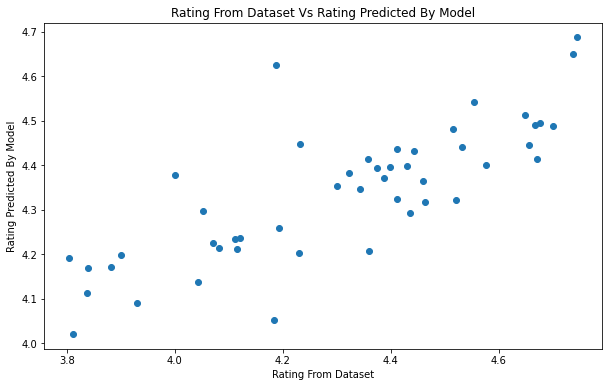

In [66]:
plt.scatter(agg_grouped_test_set['Rating\r'], agg_grouped_test_set['Predicted_Y'])
plt.xlabel('Rating From Dataset')
plt.ylabel('Rating Predicted By Model')
plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
plt.title("Rating From Dataset Vs Rating Predicted By Model")